<a href="https://colab.research.google.com/github/DanieleCecca/NLP-project/blob/main/Creazione_Dataset_Ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NER Clinical DATASET creation


*Daniele Cecca*

*Matr. 914358*

*MSc Artificial Intelligence for Science and Technology*

*Email: d.cecca@campus.unimib.it*

The following code is useful to create the NER dataset, written in IOB format that will be useful to train BERT/BioBert models for ner task.

In the first part are created the functions to extract the text from a pdf.Since the final goal is to trascript these entities in a csv file the tables will be ignored for the creation of the dataset

In the second part we will call chatGpt by using API, beacuse is the only model that perform well the task by Zero-shot.
We tried different models but it seems that the only one that works is the model with the highest number on parameters.
Also we tried different prompt, but here we present just the final version.

The entities will be the following ones:
- **problema**
- **esame**
- **operazione**
- **farmaci**

## Utilities

In [80]:
!pip install pdfplumber -q

In [81]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [82]:
import pdfplumber
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import json

import spacy
from spacy.tokens import Doc, Span
from spacy import displacy

In [83]:
import logging
logging.getLogger('pdfminer').setLevel(logging.ERROR)

In [84]:
DATA_PATH='/content/drive/MyDrive/Nlp/data/Lettera di dimissione.pdf'

### Utility functions

In [85]:
def extract_text(file,num_pag):
  with pdfplumber.open(DATA_PATH) as pdf:
      page=pdf.pages[num_pag]
      all_text=page.extract_text()
      return all_text

In [86]:
def extract_tables(file,num_pag):
  with pdfplumber.open(DATA_PATH) as pdf:
      page=pdf.pages[num_pag]
      all_tables=page.extract_tables()
      return all_tables

In [87]:
def get_text_to_remove(all_tables):
  text_to_remove=[]
  if (len(all_tables)>1):
    for i in range(0,len(all_tables)):
      all_tables[i]=np.array(all_tables[i])
      text_to_remove.extend([str(" ".join(row)).replace(" ", "").replace('\n', "") for row in all_tables[i]])
  else:
    all_tables=np.array(all_tables)
    all_tables_=all_tables.reshape(-1,np.shape(all_tables)[-1])
    text_to_remove.extend([str(" ".join(row)).replace(" ", "").replace('\n', "") for row in all_tables_])
  return text_to_remove

In [88]:
def remove_tables(all_text,text_to_remove):
  clean_text=all_text
  for row in clean_text.split('\n'):
    row_=row.replace(" ", "")
    row_=row_.replace('\n', "")
    if row_ in text_to_remove:
          clean_text = clean_text.replace(row+'\n', '')
  return clean_text

#GESTIRE CASO LIM EMOCROMO - MCHC (Conc.Emoglobinica 341 g/L 310 - 360 20/01/2025 Corpusc.Media)
#Non viene eliminato perchè extract text and extract tables lo trascivono i 2 modi diversi, ectract tables è qiello giusto
#Problema quando nella cella dell'excel va a capo

In [89]:
def get_cleaned_text(all_text,all_tables):
  if len(all_tables)>0:
    text_to_remove=get_text_to_remove(all_tables)
    cleaned_text=remove_tables(all_text,text_to_remove)
  else:
    cleaned_text=all_text
  return cleaned_text


In [90]:
def extract_all_pages(DATA_PATH):
  list_cleaned_text=[]
  with pdfplumber.open(DATA_PATH) as pdf:
    num_pages= len(pdf.pages) #number of pages in
    print(num_pages)

    for i in range(num_pages):
      print("Page: "+str(i))
      all_text=extract_text(DATA_PATH,i)
      all_tables=extract_tables(DATA_PATH,i)
      print(f"Tables:{all_tables}")
      cleaned_text=get_cleaned_text(all_text,all_tables)
      list_cleaned_text.append(cleaned_text)
  return list_cleaned_text

## Extraction Data from PDF

In [91]:
all_text=extract_text(DATA_PATH,5)
all_tables=extract_tables(DATA_PATH,5)

In [92]:
print(all_text)
print(all_tables)

RELAZIONE CLINICA alla DIMISSIONE - Definitiva
Esame/Prestazione Valore Unità di misura Intervallo Data
S-UREA 58 mg/dL 10 - 50 27/01/2025
S-BILIRUBINA INDIRETTA 0.24 mg/dL 0.01 - 0.8 27/01/2025
S-BILIRUBINA TOTALE 0.41 mg/dL 0.1 - 1 27/01/2025
S-BILIRUBINA DIRETTA 0.17 mg/dL 0.01 - 0.25 27/01/2025
S-SODIO 138.8 mmol/L 135 - 148 27/01/2025
S-POTASSIO 4.37 mmol/L 3.5 - 5 27/01/2025
S-CALCIO 2.14 mmol/L 2.1 - 2.6 27/01/2025
S-CREATINFOSFOCHINASI 308 U/L 20 - 195 27/01/2025
S-PROPEPTIDE NATRIURETICO NT-proBNP 816 pg/mL 0 - 227 27/01/2025
S-ASPARTATO AMINOTRANSFERASI 32 U/L 5 - 35 27/01/2025
S-ALANINA AMINOTRANSFERASI 33 U/L 6 - 59 27/01/2025
S-LATTICODEIDROGENASI 294 U/L 125 - 220 27/01/2025
S-PROTEINA C REATTIVA 51.2 mg/L < 6 27/01/2025
S-TROPONINA T 310 ng/L < 14 27/01/2025
S-CREATININA 1.05 mg/dL 0.5 - 1.25 27/01/2025
PT vers.2 - Secondi 8.93 Secondi 27/01/2025
PT vers.2 - Rapporto 0.91 0.85 - 1.15 27/01/2025
PT vers.2 - INR -International Normalized Ratio- 0.92 27/01/2025
APTT vers.2 

In [93]:
cleaned_text=get_cleaned_text(all_text,all_tables)

In [94]:
print(cleaned_text)

RELAZIONE CLINICA alla DIMISSIONE - Definitiva
Esame/Prestazione Valore Unità di misura Intervallo Data
Esami strumentali e visite specialistiche
Condizione cliniche alla dimissione
Discrete condizioni generali.
Terapia al domicilio
DSAN 035/4 convalidato
Numero Cartella 2025003002
stampato27/01/2025 10:53 Pag 6 / 7
Referto firmato digitalmente secondo la norma vigente.(cid:9) Firmatario NASCIMBENE SIMONA IRENE ROSA.
Data e ora della firma: 27/01/2025 10.53.30.


In [95]:
list_cleaned_text_all=extract_all_pages(DATA_PATH)

7
Page: 0
Tables:[]
Page: 1
Tables:[]
Page: 2
Tables:[[['Gruppo sanguigno', '0', '', '', '20/01/2025'], ['Fattore RH', 'Positivo', '', '', '20/01/2025'], ['Ricerca Anticorpi Irregolari', 'Negativo', '', '', '20/01/2025'], ['Numero riferimento', '2502542', '', '', '20/01/2025'], ['EMOCROMO - Globuli bianchi', '6.5', '10^9/L', '4.8 - 10.8', '20/01/2025'], ['EMOCROMO - Globuli rossi', '4.78', '10^12/L', '4.7 - 6.1', '20/01/2025'], ['EMOCROMO - Ematocrito', '43.4', '%', '42 - 52', '20/01/2025'], ['EMOCROMO - MCV (Volume Globulare Medio)', '90.8', 'fL', '80 - 94', '20/01/2025'], ['EMOCROMO - MCH (Emoglobina Corpuscolare Media)', '31.0', 'pg/Cell', '27 - 34', '20/01/2025'], ['EMOCROMO - RDW (Ind.Distribuzione Eritrocitaria)', '12.6', 'CV %', '11.5 - 14.5', '20/01/2025'], ['PIASTRINE - Piastrine', '180', '10^9/L', '130 - 400', '20/01/2025'], ['PIASTRINE - MPV (Volume Piastrinico Medio)', '9.6', 'fL', '9.1 - 12.5', '20/01/2025'], ['FORMULA - Neutrofili', '56.1', '%', '40 - 75', '20/01/2025'], 

In [96]:
df_all_pages=pd.DataFrame(list_cleaned_text_all,columns=['text'])
df_all_pages.head()

,text
0,Dipartimento Cardiotoracovascolare\nU.O. Cardi...
1,RELAZIONE CLINICA alla DIMISSIONE - Definitiva...
2,RELAZIONE CLINICA alla DIMISSIONE - Definitiva...
3,RELAZIONE CLINICA alla DIMISSIONE - Definitiva...
4,RELAZIONE CLINICA alla DIMISSIONE - Definitiva...


## Inference LLM to create NER dataset

### Utility functions

In [97]:
def sendLLM(prompt_text,model='gemini-2.0-flash'):
    # API endpoint URL (using f-string to insert the key securely)
  url = f"https://generativelanguage.googleapis.com/v1beta/models/{model}:generateContent?key={api_key}"

  # Request headers
  headers = {
      'Content-Type': 'application/json'
  }

  # Request body data (using a Python dictionary, then converting to JSON)
  data = {
    "contents": [{
      "parts":[{"text": prompt_text}]
      }]
  }
  # Convert Python dict to JSON string
  json_data = json.dumps(data)

  # --- Check if API Key exists ---
  if not api_key:
    print("Error: Secret 'GEMINI_API_KEY' not found.")
    print("Please add it using the Key icon (🔑) in the left sidebar.")
  else:
    # --- Construct the curl command safely ---
    # Use shlex.quote to handle potential special characters in data
    command = [
        "curl",
        "-X", "POST",
        "-H", f"Content-Type: {headers['Content-Type']}",
        "-d", json_data, # Send the JSON string as data
        url # The URL with the API key
    ]

    # --- Execute the command ---
    print("Sending request to Gemini API...")
    # Using subprocess for more control over execution and output capture
    process = subprocess.run(command, capture_output=True, text=True, check=False)

    # --- Print the results ---
    print("\n--- Status Code ---")
    print(process.returncode) # 0 usually means success

    print("\n--- Response (stdout) ---")
    try:
        response_json = json.loads(process.stdout)
        return response_json
        #print(json.dumps(response_json, indent=2))
    except json.JSONDecodeError:
        print(process.stdout)

    #print("\n--- Error Output (stderr) ---")
    #print(process.stderr)


In [98]:
def create_dataset_IOB(list_cleaned_text_all,prompt_base,model='gemini-2.0-flash'):
  response_text=''
  i=0
  for text in list_cleaned_text_all:
    print(f"Page:{i}")
    prompt_text=prompt_base+text
    response_json=sendLLM(prompt_text,model)
    print(response_json)
    #is the response start directly with[{} remove [8:3]
    response_text+=response_json['candidates'][0]['content']['parts'][0]['text'][8:-3]+'<separator>'
    i+=1


  return response_text


In [99]:
def create_dataframe(response_all_tex):
  df_dataset_IOB = pd.DataFrame()
  for response in response_all_tex.split('<separator>')[:-1]:
    # Attempt to parse the response as JSON
    try:
      dict_response = json.loads(response)
    # If JSONDecodeError occurs, print the offending response and skip it
    except json.JSONDecodeError as e:
      print(f"Error parsing JSON: {e}")
      print(f"Offending response: {response}")
      continue  # Skip to the next response

    df_dataset_IOB = pd.concat([df_dataset_IOB, pd.DataFrame.from_dict(dict_response)])
  return df_dataset_IOB

### Gemini models

In [100]:
from google.colab import userdata
import json # Import json library for better data handling
import shlex # Import shlex for safer command construction
import subprocess # Import subprocess for running commands

# --- Configuration ---
# Retrieve the API key from Colab Secrets
api_key = userdata.get('GEMINI_API_KEY')

In [101]:
prompt_base="""Sei un medico e voglio che mi  assegni ad ogni parola una label, seguendo il formato IOB, usato per i task di NER.
Le entità sono le seguenti:
-PROBLEMA
-ESAME
-FARMACI
-OPERAZIONE


Con problema intendiamo anche malattie. Mentre con esame , intendiamo sia esame clinico che strumentale. Considera sia il nome dell'esame sia il valore-risultato dell'esame che puo' essere sia numerico che categorico. Lo stesso vale per i problemi per i farmaci e per le operazioni.

Assegna le label frase per frase

Dammi come output solo una tabella con 2 colonne in forato JSON:
-frase:(stringa che contiene la frase a cui sono state assegnate le label)
-label:(stringa di label)

Fai attenzione il numero di parole presenti nella prima colonna devono essere uguali al numero di label presenti nella seconda.
Non aggiungere ulteriori label al di fuori di:
O
I_PROBLEMA
B_PROBLEMA
I_ESAME
B_ESAME
I_FARMACI
B_FARMACI
I_OPERAZIONE
B_OPERAZION

"""
context="context: "+cleaned_text

#### Gemini 2.0

In [102]:
response_all_tex_2=create_dataset_IOB(list_cleaned_text_all,prompt_base,model='gemini-2.0-flash')

Page:0
Sending request to Gemini API...

--- Status Code ---
0

--- Response (stdout) ---
{'candidates': [{'content': {'parts': [{'text': '```json\n[\n  {\n    "frase": "Dipartimento Cardiotoracovascolare",\n    "label": "O O"\n  },\n  {\n    "frase": "U.O. Cardiochirurgia",\n    "label": "O O"\n  },\n  {\n    "frase": "Direttore Prof . Francesco Maisano",\n    "label": "O O O O"\n  },\n  {\n    "frase": "RELAZIONE CLINICA alla DIMISSIONE - Definitiva",\n    "label": "O O O O O"\n  },\n  {\n    "frase": "Milano , il 27/01/2025",\n    "label": "O O O O"\n  },\n  {\n    "frase": "Alla cortese attenzione del medico curante",\n    "label": "O O O O O O"\n  },\n  {\n    "frase": "Si dimette in data 27/01/2025",\n    "label": "O O O O O"\n  },\n  {\n    "frase": "il Sig . RICCA MASSIMO",\n    "label": "O O O O"\n  },\n  {\n    "frase": "Nato il 17/02/1966 telefono 3287351755 Numero Cartella 2025003002",\n    "label": "O O O O O O O O"\n  },\n  {\n    "frase": "ricoverato presso questo ospeda

In [103]:
df_dataset_IOB_2=create_dataframe(response_all_tex_2)

In [104]:
df_dataset_IOB_2.head(15)

,frase,label
0,Dipartimento Cardiotoracovascolare,O O
1,U.O. Cardiochirurgia,O O
2,Direttore Prof . Francesco Maisano,O O O O
3,RELAZIONE CLINICA alla DIMISSIONE - Definitiva,O O O O O
4,"Milano , il 27/01/2025",O O O O
5,Alla cortese attenzione del medico curante,O O O O O O
6,Si dimette in data 27/01/2025,O O O O O
7,il Sig . RICCA MASSIMO,O O O O
8,Nato il 17/02/1966 telefono 3287351755 Numero ...,O O O O O O O O
9,ricoverato presso questo ospedale dal 20/01/2025,O O O O O O


## Exploration of the datasets and comparisons

### Utility functions

In [105]:
def visualize_iob_sentence(row):
    """
    Visualizza una frase con le etichette IOB usando spaCy, con colori diversi per ogni label.
    :param row: Una riga di un DataFrame Pandas contenente 'frase' e 'label'.
    """
    nlp = spacy.blank("it")  # Carichiamo un modello vuoto per l'italiano
    words = row['frase'].split()
    labels = row['label'].split()

    doc = Doc(nlp.vocab, words=words)

    ents = []
    current_entity = []
    current_label = None

    for i, (word, label) in enumerate(zip(words, labels)):
        if label.startswith("B_"):
            if current_entity:
                ents.append(Span(doc, current_entity[0], current_entity[-1] + 1, label=current_label))
            current_entity = [i]
            current_label = label[2:]
        elif label.startswith("I_") and current_entity:
            current_entity.append(i)

    if current_entity:
        ents.append(Span(doc, current_entity[0], current_entity[-1] + 1, label=current_label))

    doc.ents = ents

    colors = {label: f"hsl({hash(label) % 360}, 70%, 70%)" for label in set(l[2:] for l in labels)}
    options = {"ents": list(colors.keys()), "colors": colors}

    return displacy.render(doc, style="ent", jupyter=True, options=options)




In [106]:
def preprocess_iob_dataframe(df):
    new_data = []

    for index, row in df.iterrows():
        sentence = row['frase']
        labels = row['label']

        words = sentence.split()
        label_list = labels.split()

        if len(words) != len(label_list):
            print(f"Mismatch in row {index}, sentence '{sentence}'. Skipping this row.")
            continue

        for i in range(len(words)):
            new_data.append([index, words[i], label_list[i], sentence])

    return pd.DataFrame(new_data, columns=["#Sentence", "Word", "Label", "Sentence"])


### Dataset exploration

In [107]:
df_dataset_IOB_2.iloc[22]

,22
frase,Anamnesi patologica prossima e remota :
label,O O O O O O


In [108]:
visualize_iob_sentence(df_dataset_IOB_2.iloc[23])

In [109]:
# Create the new DataFrame
new_df = preprocess_iob_dataframe(df_dataset_IOB_2)

# Print the first few rows of the new DataFrame
new_df.head()

Mismatch in row 2, sentence 'Direttore Prof . Francesco Maisano'. Skipping this row.
Mismatch in row 3, sentence 'RELAZIONE CLINICA alla DIMISSIONE - Definitiva'. Skipping this row.
Mismatch in row 7, sentence 'il Sig . RICCA MASSIMO'. Skipping this row.
Mismatch in row 12, sentence 'sostituzione di radice aortica con protesi vascolare ( Vascutek n.32 ) con reimpianto degli osti'. Skipping this row.
Mismatch in row 20, sentence 'Nega abitudine tabagica .'. Skipping this row.
Mismatch in row 25, sentence 'in data 01/10/24 viene ricoverato presso l'ospedale di Imperia per intervento chirurgico di ernia inguinale'. Skipping this row.
Mismatch in row 27, sentence 'Durante gli accertamenti è stato fatto un ECG con riscontro elettrocardiografico di BBDx e pertanto'. Skipping this row.
Mismatch in row 29, sentence 'In data 11/10/24 visita cardiologia al ospedale di Imperia con ecocardiogramma che dimostra : VS Td 59 mm ,'. Skipping this row.
Mismatch in row 30, sentence 'ipertrofia del setto 

,#Sentence,Word,Label,Sentence
0,0,Dipartimento,O,Dipartimento Cardiotoracovascolare
1,0,Cardiotoracovascolare,O,Dipartimento Cardiotoracovascolare
2,1,U.O.,O,U.O. Cardiochirurgia
3,1,Cardiochirurgia,O,U.O. Cardiochirurgia
4,4,Milano,O,"Milano , il 27/01/2025"


In [110]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   #Sentence  491 non-null    int64 
 1   Word       491 non-null    object
 2   Label      491 non-null    object
 3   Sentence   491 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.5+ KB


In [111]:
print(f"Number of tags:{len(new_df['Label'].unique())}")
frequencies = new_df['Label'].value_counts()
frequencies

Number of tags:9


,count
Label,
O,405
B_PROBLEMA,25
I_PROBLEMA,24
B_ESAME,13
I_ESAME,12
I_OPERAZIONE,4
B_OPERAZIONE,4
B_FARMACI,3
I_FARMACI,1


In [112]:
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:]] = count
        else:
            tags[tag[2:]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('PROBLEMA', 24), ('ESAME', 12), ('OPERAZIONE', 4), ('FARMACI', 1)]


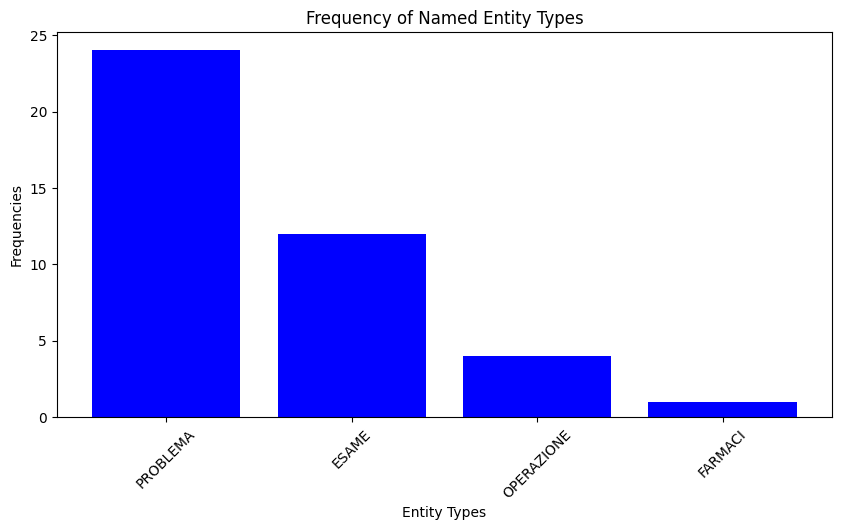

In [113]:
# Extract labels and values
labels = list(tags.keys())
values = list(tags.values())

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color="blue")

# Add labels and title
plt.xlabel("Entity Types")
plt.ylabel("Frequencies")
plt.title("Frequency of Named Entity Types")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the histogram
plt.show()

In [114]:
# Fill NaN values in 'Sentence #' by forward filling (so each word has a sentence number)
new_df["#Sentence"] = new_df["#Sentence"].ffill()

# Count named entities per sentence (Tags that are not 'O')
entity_counts = new_df[new_df["Label"] != "0"].groupby("#Sentence").size()

# Display summary statistics and first few counts
entity_counts.describe(), entity_counts.head()

(count    55.000000
 mean      8.927273
 std       6.962478
 min       1.000000
 25%       4.500000
 50%       8.000000
 75%      11.000000
 max      30.000000
 dtype: float64,
 #Sentence
 0    26
 1    11
 2    15
 3     6
 4     9
 dtype: int64)

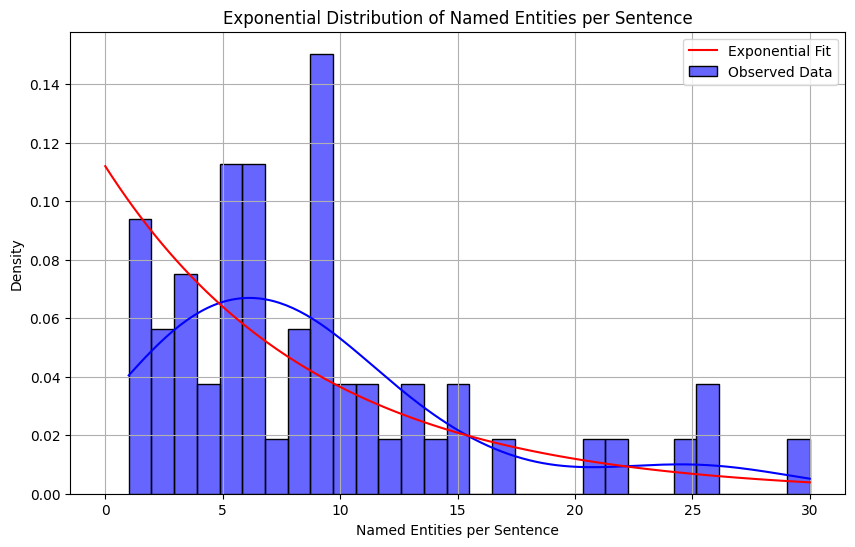

In [115]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Plot histogram
sns.histplot(entity_counts, bins=30, kde=True, stat="density", color="blue", alpha=0.6, label="Observed Data")

# Fit and plot the exponential distribution
lambda_param = 1 / entity_counts.mean()  # Exponential distribution parameter (1/mean)
x = np.linspace(0, entity_counts.max(), 100)
y = lambda_param * np.exp(-lambda_param * x)
plt.plot(x, y, color="red", label="Exponential Fit")

# Labels and title
plt.xlabel("Named Entities per Sentence")
plt.ylabel("Density")
plt.title("Exponential Distribution of Named Entities per Sentence")
plt.legend()
plt.grid()

# Show the plot
plt.show()

## Divide dataset in train-test

In [118]:
train_size = 0.8
train_dataset = df_dataset_IOB_2.sample(frac=train_size,random_state=200)
test_dataset = df_dataset_IOB_2.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df_dataset_IOB_2.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (208, 2)
TRAIN Dataset: (166, 2)
TEST Dataset: (4, 2)


### Save Dataset

In [120]:
df_dataset_IOB_2.to_csv('/content/drive/MyDrive/Nlp/data/dataset_gemini.csv', index=False, encoding='utf-8')

In [121]:
new_df.to_csv('/content/drive/MyDrive/Nlp/data/augmented_dataset_gemini.csv', index=False, encoding='utf-8')

In [122]:
train_dataset.to_csv('/content/drive/MyDrive/Nlp/data/training_gemini.csv', index=False, encoding='utf-8')

In [123]:
test_dataset.to_csv('/content/drive/MyDrive/Nlp/data/test_gemini.csv', index=False, encoding='utf-8')